# Part 2: CNN Classification

## Introduction

In this part, you'll implement a Convolutional Neural Network (CNN) for EMNIST character recognition. You can choose between TensorFlow/Keras or PyTorch for implementation. This will help you understand CNNs and their advantages for image classification tasks.

## Learning Objectives

- Implement a CNN using either TensorFlow/Keras or PyTorch
- Apply convolutional layers, pooling, and batch normalization
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [2]:
# Install required packages
#%pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing

2025-05-28 04:13:28.558151: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-28 04:13:29.109862: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-28 04:13:47.828372: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-28 04:13:52.232090: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training data shape: (71040, 28, 28)
Test data shape: (17760, 28, 28)
Number of classes: 26


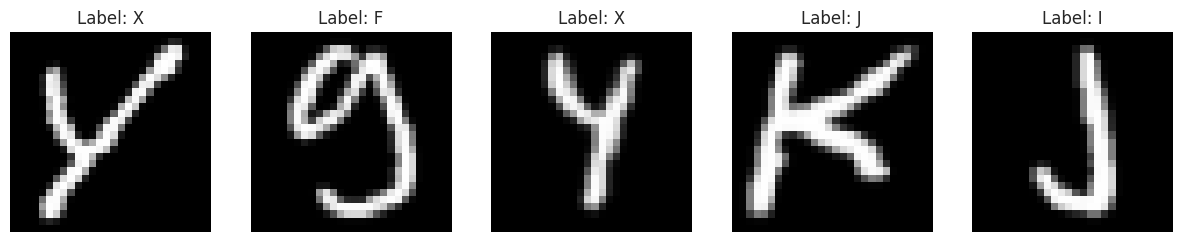

In [4]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

# Load EMNIST dataset
datasets, info = tfds.load(
    'emnist/letters',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

train_ds, test_ds = datasets

# Convert to NumPy arrays
x_train, y_train = zip(*[(img.numpy().squeeze(), lbl.numpy() - 1) for img, lbl in train_ds])
x_test, y_test = zip(*[(img.numpy().squeeze(), lbl.numpy() - 1) for img, lbl in test_ds])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].T, cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [5]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (56832, 28, 28, 1)
Preprocessed validation data shape: (14208, 28, 28, 1)
Preprocessed test data shape: (17760, 28, 28, 1)


## 2. Model Implementation

### TensorFlow/Keras Implementation

In [15]:
# Create CNN using Keras

from tensorflow.keras import layers, models

def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.
    
    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate
    
    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        # First conv block
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second conv block
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(26, activation="softmax"),
    ])
    
    # Compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create and compile model
keras_model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
keras_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,610 (482.85 KB)

 Trainable params: 123,290 (481.60 KB)

 Non-trainable params: 320 (1.25 KB)

### PyTorch Implementation

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        """
        Create a CNN using PyTorch.
        
        Requirements:
        - Must use at least 2 convolutional layers
        - Must include pooling and batch normalization
        
        Goals:
        - Achieve > 85% accuracy on test set
        - Minimize overfitting using batch normalization and dropout
        - Train efficiently with appropriate batch size and learning rate
        
        Args:
            num_classes: Number of output classes (26 for letters)
        """

        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2) # 14x14

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2) # 7x7

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout2d(0.3)

        # After 2x maxpool on 28x28 to 14x14 to 7x7 to flatten (64×7×7 = 3136)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

    
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)  # MaxPool2d

        # Second conv block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(x)

        # Flatten
        x = x.reshape(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
    
        return x

# Create model
pytorch_model = CNN(num_classes=26)
print(pytorch_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (bn_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


## 3. Training and Evaluation

### TensorFlow/Keras Training

Epoch 1/20


2025-05-28 05:01:18.301812: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 178225152 exceeds 10% of free system memory.


1776/1776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6992 - loss: 1.0581

2025-05-28 05:01:56.935045: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44556288 exceeds 10% of free system memory.


1776/1776 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.6992 - loss: 1.0578 - val_accuracy: 0.8898 - val_loss: 0.3288 - learning_rate: 0.0010
Epoch 2/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.8793 - loss: 0.3822 - val_accuracy: 0.9049 - val_loss: 0.2836 - learning_rate: 0.0010
Epoch 3/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9000 - loss: 0.3099 - val_accuracy: 0.9113 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 4/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.9121 - loss: 0.2689 - val_accuracy: 0.9225 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 5/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.9209 - loss: 0.2394 - val_accuracy: 0.9207 - val_loss: 0.2421 - learning_rate: 0.0010
Epoch 6/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9236 - loss: 0.2191 - val_accuracy: 0.9205 - val_loss: 0.2413 - learning_rate: 0.0010
Epoch 7/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.9307 

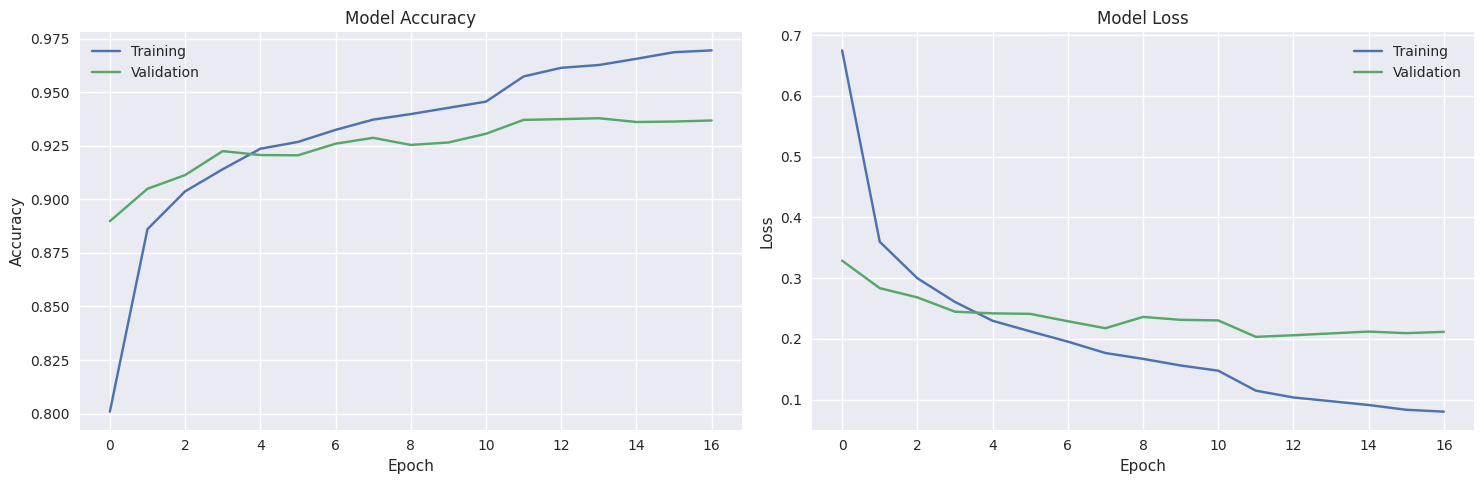

In [16]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# Train model
history = keras_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### PyTorch Training

In [46]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = pytorch_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Convert data to PyTorch tensors
x_train = torch.FloatTensor(x_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)

y_train = torch.LongTensor(np.argmax(y_train, axis=1)).to(device) if y_train.ndim > 1 else torch.LongTensor(y_train).to(device)
y_val = torch.LongTensor(np.argmax(y_val, axis=1)).to(device) if y_val.ndim > 1 else torch.LongTensor(y_val).to(device)


# Ensure the shape is (batch_size, channels, height, width)
x_train = x_train.permute(0, 2, 1, 3)
x_val = x_val.permute(0, 2, 1, 3) 

# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(20):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i in range(0, len(x_train), 32):
        batch_x = x_train[i:i+32]
        batch_y = y_train[i:i+32]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()
    
    train_loss = train_loss / (len(x_train) / 32)
    train_acc = train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i in range(0, len(x_val), 32):
            batch_x = x_val[i:i+32]
            batch_y = y_val[i:i+32]
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()
    
    val_loss = val_loss / (len(x_val) / 32)
    val_acc = val_correct / val_total
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'models/cnn_pytorch.pt')
        # Save architecture
        with open('models/cnn_pytorch_arch.txt', 'w') as f:
            f.write(str(model))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

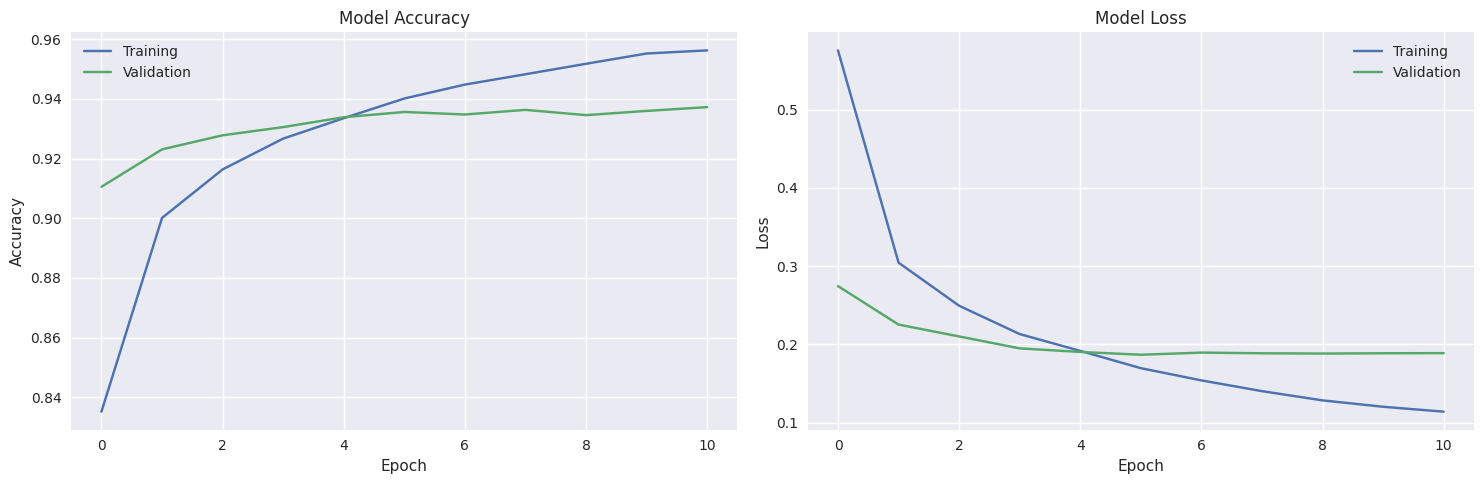

In [47]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history['train_acc'], label='Training')
ax1.plot(history['val_acc'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history['train_loss'], label='Training')
ax2.plot(history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### Performance Metrics

555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9359 - loss: 0.2196
Test accuracy: 0.9360
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


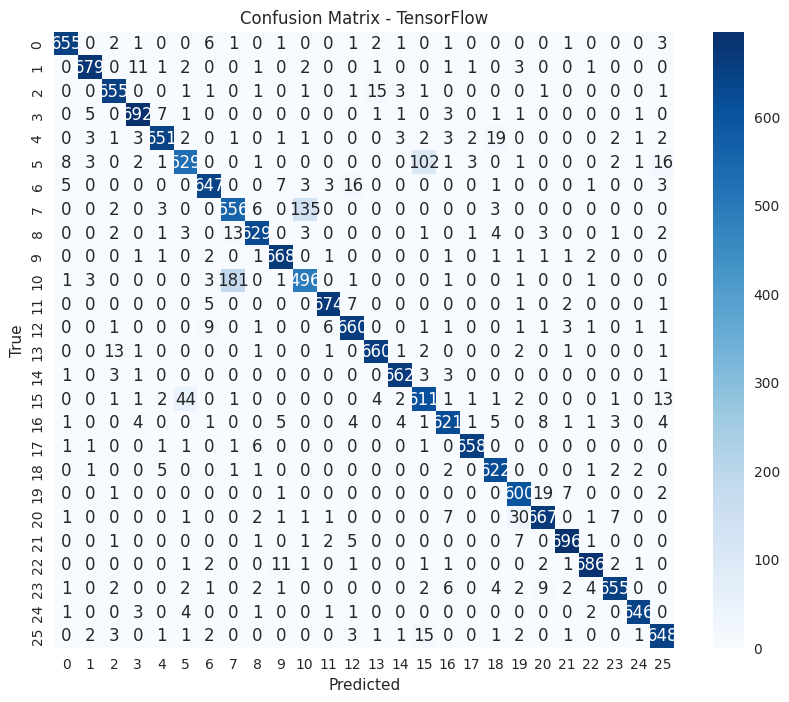

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate model
test_loss, test_accuracy = keras_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = keras_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TensorFlow')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Save metrics
os.makedirs('results/part_2', exist_ok=True)
with open('results/part_2/cnn_tensorflow_metrics.txt', 'w') as f:
    f.write("model: cnn_tensorflow\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")
    f.write(f"precision: {precision:.4f}\n")
    f.write(f"recall: {recall:.4f}\n")
    f.write(f"f1_score: {f1:.4f}\n")
    f.write(f"confusion_matrix: {cm.numpy().tolist()}\n")

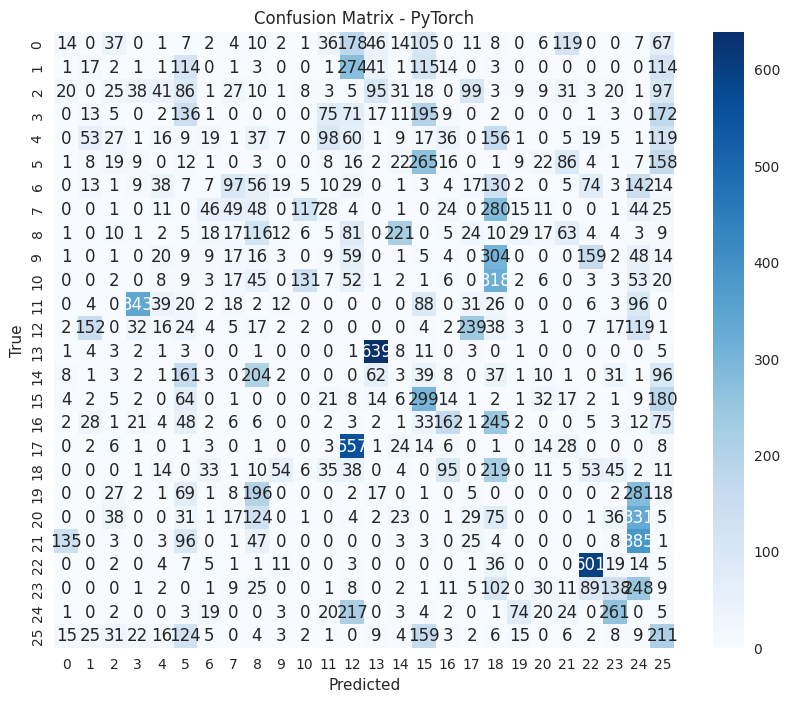

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ensure test data is shaped correctly
x_test_tensor = torch.FloatTensor(x_test).permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.LongTensor(np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test).to(device)

# Evaluate on test data
pytorch_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(0, len(x_test_tensor), 32):
        batch_x = x_test_tensor[i:i+32]
        batch_y = y_test_tensor[i:i+32]
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Calculate metrics
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
cm = tf.math.confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PyTorch')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
os.makedirs('results/part_2', exist_ok=True)
with open('results/part_2/cnn_pytorch_metrics.txt', 'w') as f:
    f.write("model: cnn_pytorch\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")
    f.write(f"precision: {precision:.4f}\n")
    f.write(f"recall: {recall:.4f}\n")
    f.write(f"f1_score: {f1:.4f}\n")
    f.write(f"confusion_matrix: {cm.numpy().tolist()}\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for CNN input
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create CNN with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in CNN layers
   - Solution: Ensure data is properly shaped (samples, height, width, channels)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters